In [ ]:
"../novels_model.pt"
"../essays_model.pt"
"../short_stories_model.pt"
"../poems_model.pt"
"../best_classification_category_bengali_transformer.pt"

In [18]:
import torch
import torch.nn as nn
from transformers import GPT2Tokenizer

# Define your custom model architecture
class CustomTransformer(nn.Module):
    def __init__(self, vocab_size, max_len=128, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.3, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        positions = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)
        x = self.embedding(input_ids) + self.position_embedding(positions)
        x = self.encoder(x, src_key_padding_mask=~attention_mask.bool())
        x = self.dropout(x[:, 0])  # Take CLS token representation
        return self.classifier(x)

# Define paths to models and tokenizers
category_model_path = "./best_classification_category_bengali_transformer.pt"
model_paths = {
    "novels": "./novels_model.pt",
    "essays": "./essays_model.pt",
    "short_stories": "./story_model.pt",
    "poems": "./poems_model.pt"
}

# Tokenizer file paths
tokenizer_files = {
    "category": {
        "vocab": "./bengali_tokenizer/vocab.json",
        "merges": "./bengali_tokenizer/merges.txt"
    },
    "novels": {
        "vocab": "./bengali_tokenizer_novels/vocab.json",
        "merges": "./bengali_tokenizer_novels/merges.txt"
    },
    "essays": {
        "vocab": "./bengali_tokenizer_essays/vocab.json",
        "merges": "./bengali_tokenizer_essays/merges.txt"
    },
    "short_stories": {
        "vocab": "./bengali_tokenizer_stories/vocab.json",
        "merges": "./bengali_tokenizer_stories/merges.txt"
    },
    "poems": {
        "vocab": "./bengali_tokenizer_poems/vocab.json",
        "merges": "./bengali_tokenizer_poems/merges.txt"
    }
}

# Category label mapping
category_labels = {0: "novels", 1: "essays", 2: "short_stories", 3: "poems"}
human_ai_labels = {0: "human", 1: "AI"}

# Model configuration parameters (MUST match your training setup)
MAX_LEN = 128  # Adjust if you used a different max length during training
D_MODEL = 512  # Adjust if you used a different dimension
NHEAD = 8      # Adjust if you used a different number of heads
NUM_LAYERS = 6 # Adjust if you used a different number of layers
DIM_FEEDFORWARD = 2048  # Adjust if you used a different feedforward dimension

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load tokenizer from vocab.json and merges.txt
def load_tokenizer(vocab_path, merges_path):
    tokenizer = GPT2Tokenizer(vocab_file=vocab_path, merges_file=merges_path)
    
    # IMPORTANT: Don't add new tokens - just assign existing token as pad token
    if tokenizer.pad_token is None:
        # Use an existing token as pad token without adding new tokens
        tokenizer.pad_token = tokenizer.eos_token
    
    return tokenizer

# Function to load custom model with vocabulary size handling
def load_custom_model(model_path, tokenizer, num_classes):
    vocab_size = len(tokenizer)
    
    # Initialize a fresh model
    model = CustomTransformer(
        vocab_size=vocab_size,
        max_len=MAX_LEN,
        d_model=D_MODEL,
        nhead=NHEAD,
        num_layers=NUM_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        num_classes=num_classes
    )

    checkpoint = torch.load(model_path, map_location=device)

    # Case 1: Entire model was saved
    if isinstance(checkpoint, nn.Module):
        print(f"Loaded full model from {model_path}")
        model = checkpoint
        model.to(device)
        model.eval()
        return model

    # Case 2: state_dict was saved
    elif isinstance(checkpoint, dict):
        state_dict = checkpoint

        # Handle DataParallel case (keys with "module.")
        if any(k.startswith("module.") for k in state_dict.keys()):
            print("Stripping 'module.' prefixes from state_dict...")
            new_state_dict = {}
            for k, v in state_dict.items():
                new_state_dict[k.replace("module.", "")] = v
            state_dict = new_state_dict

        # Handle vocab mismatch in embeddings
        model_vocab_size = model.embedding.weight.shape[0]
        if "embedding.weight" in state_dict:
            checkpoint_vocab_size = state_dict["embedding.weight"].shape[0]
            
            if model_vocab_size != checkpoint_vocab_size:
                print(f"Warning: Vocabulary size mismatch. "
                      f"Model has {model_vocab_size}, checkpoint has {checkpoint_vocab_size}")

                if checkpoint_vocab_size < model_vocab_size:
                    new_embedding = nn.Embedding(model_vocab_size, D_MODEL)
                    new_embedding.weight.data[:checkpoint_vocab_size] = state_dict["embedding.weight"]
                    eos_token_id = tokenizer.eos_token_id
                    if eos_token_id < checkpoint_vocab_size:
                        for i in range(checkpoint_vocab_size, model_vocab_size):
                            new_embedding.weight.data[i] = state_dict["embedding.weight"][eos_token_id]
                    else:
                        new_embedding.weight.data[checkpoint_vocab_size:] = 0
                    model.embedding = new_embedding
                    del state_dict["embedding.weight"]

        model.load_state_dict(state_dict, strict=False)

    else:
        raise ValueError(f"Unrecognized checkpoint format in {model_path}")

    model.to(device)
    model.eval()
    return model


# Load category tokenizer
category_tokenizer = load_tokenizer(
    tokenizer_files["category"]["vocab"],
    tokenizer_files["category"]["merges"]
)

# Load category model (4 classes: novels, essays, short_stories, poems)
category_model = load_custom_model(
    category_model_path,
    category_tokenizer,
    num_classes=len(category_labels)
)

# Load category-specific tokenizers and models
tokenizers = {}
models = {}

for category in model_paths:
    # Load tokenizer
    tokenizers[category] = load_tokenizer(
        tokenizer_files[category]["vocab"],
        tokenizer_files[category]["merges"]
    )
    
    # Load model (2 classes: human, AI)
    models[category] = load_custom_model(
        model_paths[category],
        tokenizers[category],
        num_classes=len(human_ai_labels)
    )

def classify_text(text):
    # Step 1: Classify category
    inputs = category_tokenizer(
        text, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=MAX_LEN
    ).to(device)
    
    with torch.no_grad():
        outputs = category_model(**inputs)   # logits directly
        category_pred = torch.argmax(outputs, dim=1).item()
        predicted_category = category_labels[category_pred]
    
    # Step 2: Classify human vs AI using the corresponding model
    tokenizer = tokenizers[predicted_category]
    model = models[predicted_category]
    
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=MAX_LEN
    ).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)   # logits directly
        human_ai_pred = torch.argmax(outputs, dim=1).item()
        predicted_human_ai = human_ai_labels[human_ai_pred]
    
    return predicted_category, predicted_human_ai


# Example usage
text_samples = [
    "এটি একটি বাংলা উপন্যাসের নমুনা পাঠ্য।",
    "এটি একটি প্রবন্ধ যা সমাজের বিভিন্ধ দিক নিয়ে আলোচনা করে।",
    "একটি ছোট গল্প যা গ্রামের জীবনের কথা বলে।",
    "একটি কবিতা যা প্রকৃতির সৌন্দর্য বর্ণনা করে।"
]

for text in text_samples:
    category, human_ai = classify_text(text)
    print(f"Text: {text}")
    print(f"Predicted Category: {category}")
    print(f"Predicted Source: {human_ai}")
    print("-" * 50)

Text: এটি একটি বাংলা উপন্যাসের নমুনা পাঠ্য।
Predicted Category: novels
Predicted Source: AI
--------------------------------------------------
Text: এটি একটি প্রবন্ধ যা সমাজের বিভিন্ধ দিক নিয়ে আলোচনা করে।
Predicted Category: short_stories
Predicted Source: human
--------------------------------------------------
Text: একটি ছোট গল্প যা গ্রামের জীবনের কথা বলে।
Predicted Category: novels
Predicted Source: AI
--------------------------------------------------
Text: একটি কবিতা যা প্রকৃতির সৌন্দর্য বর্ণনা করে।
Predicted Category: short_stories
Predicted Source: human
--------------------------------------------------


In [20]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Load dataset
data = pd.read_csv("../../Unseen Data/Paraphrased_dataset.csv")

# Collect predictions
true_labels = []
pred_labels = []
pred_categories = []

for _, row in data.iterrows():
    text = row["text"]
    true_label = row["label"].lower()   # 'human' or 'ai'
    
    predicted_category, predicted_source = classify_text(text)
    
    true_labels.append(true_label)
    pred_labels.append(predicted_source.lower())
    pred_categories.append(predicted_category)

# Convert to lists
true_labels = list(true_labels)
pred_labels = list(pred_labels)

# Classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=["human", "ai"]))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=["human", "ai"])
print("Confusion Matrix:")
print(cm)


Classification Report:
              precision    recall  f1-score   support

       human       0.33      0.22      0.26      1500
          ai       0.41      0.54      0.47      1500

    accuracy                           0.38      3000
   macro avg       0.37      0.38      0.37      3000
weighted avg       0.37      0.38      0.37      3000

Confusion Matrix:
[[ 809  691]
 [1166  334]]


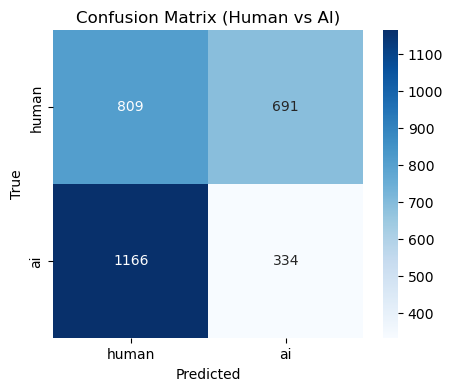

In [21]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["human", "ai"],
            yticklabels=["human", "ai"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Human vs AI)")
plt.show()

In [22]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Load dataset
data = pd.read_csv("../../Unseen Data/Unseen_dataset.csv")

# Collect predictions
true_labels = []
pred_labels = []
pred_categories = []

for _, row in data.iterrows():
    text = row["text"]
    true_label = row["label"].lower()   # 'human' or 'ai'
    
    predicted_category, predicted_source = classify_text(text)
    
    true_labels.append(true_label)
    pred_labels.append(predicted_source.lower())
    pred_categories.append(predicted_category)

# Convert to lists
true_labels = list(true_labels)
pred_labels = list(pred_labels)

# Classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=["human", "ai"]))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=["human", "ai"])
print("Confusion Matrix:")
print(cm)


Classification Report:
              precision    recall  f1-score   support

       human       0.51      0.46      0.48      2000
          ai       0.51      0.55      0.53      2000

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.51      4000
weighted avg       0.51      0.51      0.51      4000

Confusion Matrix:
[[1105  895]
 [1080  920]]


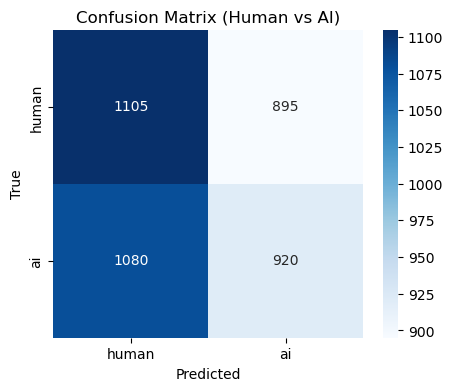

In [23]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["human", "ai"],
            yticklabels=["human", "ai"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Human vs AI)")
plt.show()